In [2]:
import tensorflow as tf
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from net.refinenet import RefineNet
%matplotlib inline

inp = tf.placeholder(tf.float32,shape=[None,224,224,4],name='input')
refine_net = RefineNet(inp,'resnet_v1_50','exp/test3/iters-24309')

net,end_points = refine_net.net,refine_net.end_points
coarse_net_end = end_points['tail/linear2']

# Attach sigmoid and reshape
coarse_out= tf.reshape(tf.sigmoid(coarse_net_end),[-1,56,56,1])
refine_out = tf.sigmoid(net)

sess = tf.InteractiveSession()
refine_net.initialize(sess,'exp/refine-test_1/iters-38609')
#saver = tf.train.Saver()
#saver.restore(sess, 'exp/test3/iters-20929')

print("Model Loaded")

Model Loaded


In [3]:
from dataprovider.preprocess import vgg_preprocess
import os
from skimage import transform
BASE_DIR = os.path.join('/work/george','DAVIS')
IMAGESETS = os.path.join('ImageSets','480p')
    
RESIZE_HEIGHT = 224
RESIZE_WIDTH = 224

def read_image(imageFile,prev_mask=None):
        
    # Fix full file path
    rgbFile =BASE_DIR + imageFile
    #maskFile = BASE_DIR + prevMaskFile
        
    # Read images 
    rgb = io.imread(rgbFile)
    rgb = transform.resize(rgb,[RESIZE_HEIGHT,RESIZE_WIDTH])

    mask = prev_mask
    
    mask = np.expand_dims(mask,axis=2)
    
    print(mask.shape)    
    # Concatenate images
    image =  np.concatenate((rgb, mask), 2)
    
    # Resize 
    
       
    #io.imshow(image[:,:,0:3])  
    print('Max',image.max(),image.min())
    image = image*255
    #plt.imshow(image[:,:,0:3].astype(np.uint8)) 
    
    
    image = np.expand_dims(image,axis=0)
    
    image = vgg_preprocess(image)
    
    return image

def read_raw_image(image_file):
    fullfile_path = BASE_DIR + image_file
    image = io.imread(fullfile_path)
    # Resize 
    image = transform.resize(image,[RESIZE_HEIGHT,RESIZE_WIDTH])
    return image

In [4]:
import re
def get_mask_file_name(image_name):
    m=re.match(r"(/.*/.*/)(.*/.*).jpg",image_name)
    frame_no = m.group(2)
    return '/Annotations/480p/{}.png'.format(frame_no)


2016-10-07 00:01:21,540 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-07 00:01:21,541 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3628
(224, 224, 1)
Max 1.0 0.0
2016-10-07 00:01:21,879 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-07 00:01:21,881 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3628
(224, 224, 1)
Max 0.965651260504 0.0
2016-10-07 00:01:22,142 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-07 00:01:22,143 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3443
(224, 224, 1)
Max 0.975490196078 0.0
2016-10-07 00:01:22,648 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-07 00:01:22,649 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3129
(224, 224, 1)
Max 0.938527047634 0.0
2016-10-07 00:01:22,904 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-07 00:01:22,904 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3155
(224, 224, 1)
Max 0.938527047634 0.0
2016-10-07 00:01:23,166 - PIL.PngImagePlugin - DEBUG - S

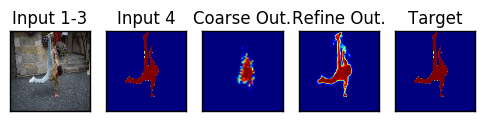

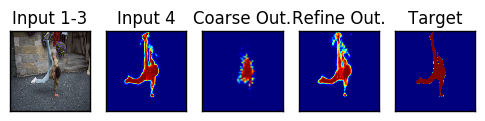

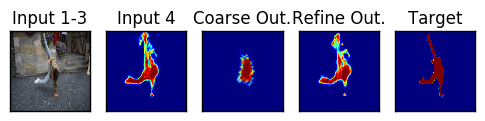

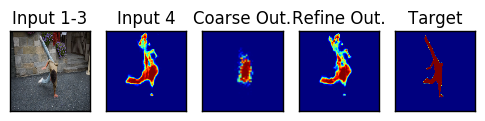

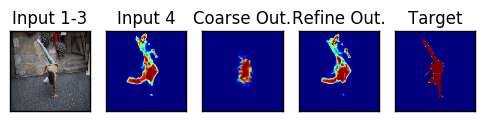

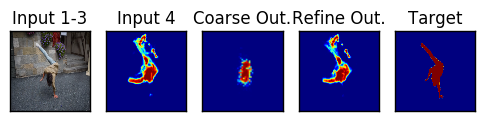

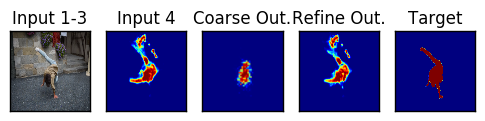

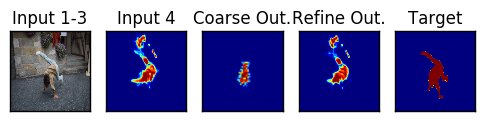

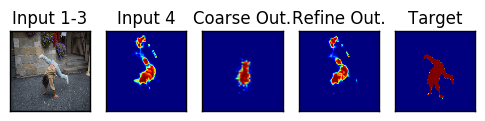

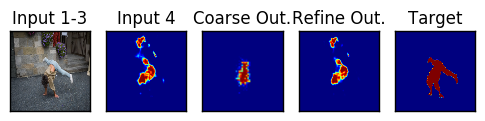

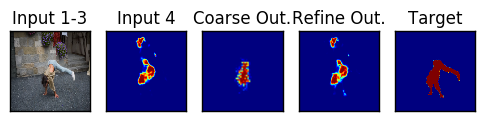

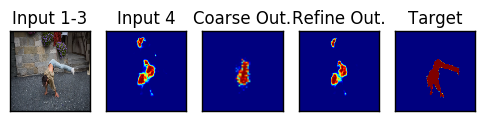

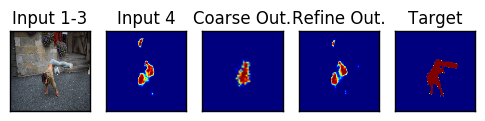

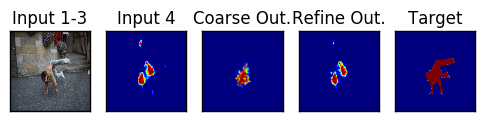

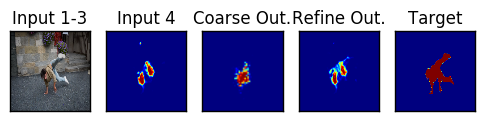

In [6]:
from skimage import morphology


img_seq = '/JPEGImages/480p/breakdance-flare/'

start_frame= 0;
end_frame = 15;



_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127

start_frame_name ='{0}{1:05}.jpg'.format(img_seq,start_frame)
mask_file_name = get_mask_file_name(start_frame_name)

prev_mask = read_raw_image(mask_file_name)


for img_no in range(start_frame,end_frame):

    image_file ='{0}{1:05}.jpg'.format(img_seq,img_no)
   
    
    image = read_image(image_file,prev_mask)
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))

    result = sess.run([coarse_out,refine_out],feed_dict={inp:image})

    plt.figure()


    #Plot input image
    plt.subplot(1,5,1)
    frame1 = plt.gca()
    frame1.axes.set_title('Input 1-3')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    rgb = image[0,:,:,0:3]
    #print(rgb.shape)
    means = [_R_MEAN, _G_MEAN ,_B_MEAN]
    rgb = rgb + means
    plt.imshow(rgb.astype(np.uint8))

    #Plot previous label
    plt.subplot(1,5,2)
    
    frame1 = plt.gca()
    frame1.axes.set_title('Input 4')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(image[0,:,:,3])

    #Plot output
    plt.subplot(1,5,3)
    frame1 = plt.gca()
    frame1.axes.set_title('Coarse Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(result[0][0,:,:,0])
    
    #Plot output
    plt.subplot(1,5,4)
    frame1 = plt.gca()
    frame1.axes.set_title('Refine Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    
    # Set previous mask
    prev_mask = result[1][0,:,:,0]
    plt.imshow(prev_mask)
    
    #Plot label
    plt.subplot(1,5,5)
    frame1 = plt.gca()
    frame1.axes.set_title('Target')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(read_raw_image(get_mask_file_name(image_file)))